# Facemask Detection Datathon

## Importing data science libraries

In [1]:
# import the necessary packages
import os                    # OS module in Python provides a way of using operating system dependent functionality
import pandas as pd          # Data analysis and manipultion tool
import numpy as np           # Fundamental package for linear algebra and multidimensional arrays
import matplotlib.pyplot as plt   # for visualization
import cv2                        # Library for image processing
import argparse
from imutils import paths
from tqdm.notebook import tqdm # widget progress bar
# Scikit-learn utils..
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.utils import class_weight, shuffle
from sklearn.model_selection import train_test_split    # For splitting the data into train and validation set

#Deep Learning Tool
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import regularizers, optimizers
from keras import models  
from keras.models import load_model
from keras.layers.convolutional import Conv2D
from keras.layers import Activation
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical

## Loading and preparing training data

In [2]:
path = os.getcwd()
train_df=pd.read_csv(path+'\\Training_set_face_mask.csv')
test_df=pd.read_csv(path+'\\Testing_set_face_mask.csv')
train_df.head() # this will display the first five rows in the dataframe

,filename,label
0,Image_1.jpg,without_mask
1,Image_2.jpg,without_mask
2,Image_3.jpg,without_mask
3,Image_4.jpg,without_mask
4,Image_5.jpg,without_mask


In [3]:
train_df.tail()            

,filename,label
11259,Image_11260.jpg,with_mask
11260,Image_11261.jpg,with_mask
11261,Image_11262.jpg,with_mask
11262,Image_11263.jpg,with_mask
11263,Image_11264.jpg,with_mask


#### Checking for class imbalances

In [4]:
train_df['label'].value_counts()
# From the values below we can see that both classes are balanced 
## (i.e. both classes have the same number of elements)

with_mask       5632
without_mask    5632
Name: label, dtype: int64

In [10]:
def prepare_data():
    file_paths = [[fname, path + '\\train\\' + fname] for fname in train_df['filename']]

    images = pd.DataFrame(file_paths, columns=['filename', 'filepaths'])
    train_data = pd.merge(images, train_df, how = 'inner', on = 'filename')
    lb = LabelBinarizer()
    labels_bin = lb.fit_transform(train_data.label) # categorical labels to binary
    train_data["labels_bin"] = lb.fit_transform(train_data.label) # categorical labels to binary
    labels_OHE =  to_categorical(labels_bin)  # One-Hot-Encoding for the labels binary
    train_data= train_data.sample(frac=1)
    return train_data.head()

def show_prepared_data():
    return train_data.tail()

In [12]:
prepare_data()
#show_prepared_data()

,filename,filepaths,label,labels_bin
811,Image_812.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask,1
15,Image_16.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask,1
10593,Image_10594.jpg,C:\Users\perro\Documents\deep_learning_final\f...,with_mask,0
157,Image_158.jpg,C:\Users\perro\Documents\deep_learning_final\f...,without_mask,1
8847,Image_8848.jpg,C:\Users\perro\Documents\deep_learning_final\f...,with_mask,0


## Data Pre-processing
Image generators take care of most data pre-processing operations. Basically, it allows you to rotate, flip or do many other operations to your images. It helps you tweak your images a little bit so that your model is able to generalze better. It can resize, one-hot encode, and normalize labels and images.

In [13]:
#target_size: tuple of integers (height, width), default: (256, 256).
#The dimensions to which all images found will be resized.

train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2,
        )
valid_datagen= ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=path+ '\\train',
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224),
)

valid_generator=valid_datagen.flow_from_dataframe(
dataframe=train_df,
directory=path+'\\train',
x_col="filename",
y_col="label",
validation_split=0.2,
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(224,224)
)

test_datagen=ImageDataGenerator(rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=path+"\\test",
x_col="filename",
y_col=None,
batch_size=32,
seed=42,
shuffle=False,
class_mode=None,
target_size=(224,224))

Found 9012 validated image filenames belonging to 2 classes.
Found 2252 validated image filenames belonging to 2 classes.
Found 1536 validated image filenames.


#### Converting the file_paths to dataframe



(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)
(224, 224, 3)


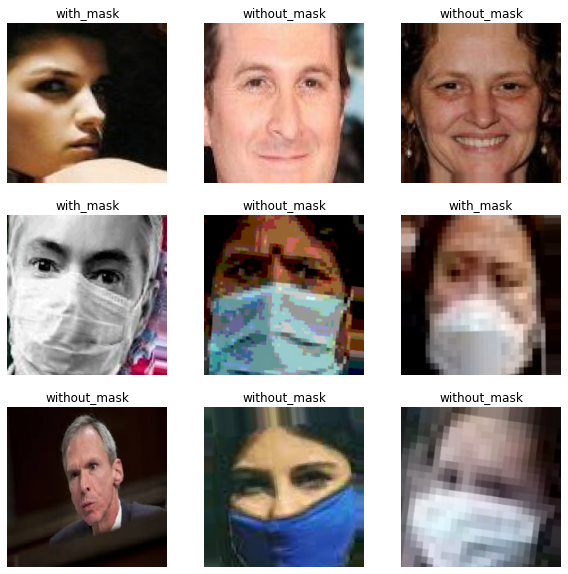

In [14]:
image_indexes = [2,4,8,16,20,21,22,23,31]
classes=['without_mask','with_mask']

def plot_images(data_generator=None):
  plt.figure(figsize=(10, 10))
  if data_generator is not None:
    images,labels=data_generator.next()
    i=0
    while i < len(image_indexes):
        ax = plt.subplot(3, 3, i + 1)
        print(images[i,:,:,:].shape)
        images[i,:,:,:]=images[image_indexes[i],:,:,:]*255.0
        plt.imshow(images[i,:,:,:].astype("uint8"))
        plt.title(classes[int(labels[i][0])])
        plt.axis("off")
        i+=1
        
plot_images(train_generator)


In [16]:
'''
# CONVOLUTIONAL ARCHITECTURE 
'''

learning_rate = 1e-4
epochs = 10

model = Sequential()
# first layer
model.add(Conv2D(32,(3,3), input_shape=(224, 224,3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

#second layer
model.add(Conv2D(32,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('softmax'))
# print(model.output_shape)
# print(model.summary())

opt = Adam(lr=learning_rate, decay=learning_rate / epochs)

model.compile(loss="binary_crossentropy", optimizer=opt, 
              metrics=["accuracy"])

#history = model.fit(data,target,epochs=1,validation_split=0.2)

# Summary of our model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 53, 53, 64)        1

## Train the head of the network


In [18]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
history=model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=3
)

Epoch 1/3
281/281 [==============================] - 365s 1s/step - loss: 0.1388 - accuracy: 0.9569 - val_loss: 0.0925 - val_accuracy: 0.9768
Epoch 2/3
281/281 [==============================] - 433s 2s/step - loss: 0.1290 - accuracy: 0.9562 - val_loss: 0.1654 - val_accuracy: 0.9388
Epoch 3/3
281/281 [==============================] - 428s 2s/step - loss: 0.1222 - accuracy: 0.9619 - val_loss: 0.1092 - val_accuracy: 0.9665


In [21]:
history.history 

{'loss': [0.13878720998764038, 0.12903940677642822, 0.12217507511377335],
 'accuracy': [0.9569042325019836, 0.9562360644340515, 0.9619153738021851],
 'val_loss': [0.09251227974891663, 0.16542893648147583, 0.10919077694416046],
 'val_accuracy': [0.9767857193946838, 0.9388392567634583, 0.9665178656578064]}

In [26]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


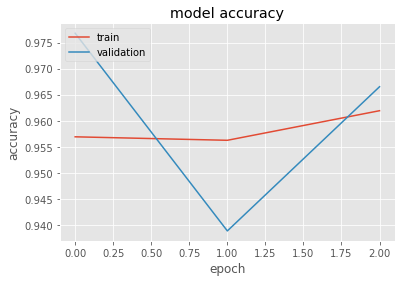

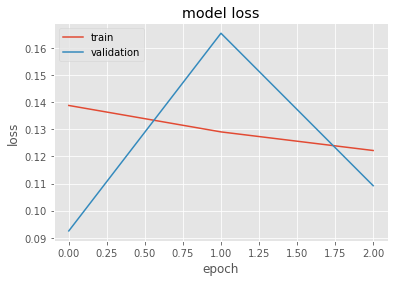

In [27]:
def plot_results(history):
  print(history.history.keys())
#  "Accuracy"
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
  # "Loss"
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()
    
plot_results(history)

In [29]:
# saving the model
save_dir = path
model_name = '\\final2.h5'
model_path = save_dir + model_name
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at C:\Users\perro\Documents\deep_learning_final\face_mask_detection\final2.h5 
